In [2]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

### Sanitizing input

In [60]:
input_filename = 'socialmedia-disaster-tweets-DFE.csv'
output_filename = 'socialmedia_relevant_cols_clean.csv'

input_file = codecs.open(input_filename, 'r', encoding='utf-8', errors='replace')
output_file = open(output_filename, 'w')

def sanitize_characters(raw, clean):
    for line in raw:
        out = line
        clean.write(line)
        
sanitize_characters(input_file, output_file)
questions = pd.read_csv(filename)
questions.drop(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'choose_one:confidence',
       'choose_one_gold', 'keyword', 'location', 'tweetid', 'userid'], axis=1, inplace=True)

cat_to_num = {
    "Relevant": 0,
    "Not Relevant": 1,
    "Can't Decide": 2
}

questions['class_label'] = questions['choose_one'].map(cat_to_num)

In [61]:
questions.head()

,choose_one,text,class_label
0,Relevant,Just happened a terrible car crash,0
1,Relevant,Our Deeds are the Reason of this #earthquake M...,0
2,Relevant,"Heard about #earthquake is different cities, s...",0
3,Relevant,"there is a forest fire at spot pond, geese are...",0
4,Relevant,Forest fire near La Ronge Sask. Canada,0


In [62]:
questions.tail()

,choose_one,text,class_label
10871,Relevant,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,0
10872,Relevant,Police investigating after an e-bike collided ...,0
10873,Relevant,The Latest: More Homes Razed by Northern Calif...,0
10874,Relevant,MEG issues Hazardous Weather Outlook (HWO) htt...,0
10875,Relevant,#CityofCalgary has activated its Municipal Eme...,0


In [63]:
questions.describe()

,class_label
count,10876.000000
mean,0.571809
std,0.497804
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


In [64]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r'http\S+', "")
    df[text_field] = df[text_field].str.replace(r'http', '')
    df[text_field] = df[text_field].str.replace(r'@\S+', '')
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv", index=False)
questions.head()

,choose_one,text,class_label
0,Relevant,just happened a terrible car crash,0
1,Relevant,our deeds are the reason of this earthquake m...,0
2,Relevant,"heard about earthquake is different cities, s...",0
3,Relevant,"there is a forest fire at spot pond, geese are...",0
4,Relevant,forest fire near la ronge sask canada,0


In [65]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,choose_one,text,class_label
10871,Relevant,m1 94 01 04 utc ?5km s of volcano hawaii,0
10872,Relevant,police investigating after an e bike collided ...,0
10873,Relevant,the latest more homes razed by northern calif...,0
10874,Relevant,meg issues hazardous weather outlook (hwo),0
10875,Relevant,cityofcalgary has activated its municipal eme...,0


In [66]:
clean_questions.groupby("class_label").count()

,choose_one,text
class_label,,
0,4673,4673
1,6187,6187
2,16,16


### Pre-processing data

In [67]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions['text'].apply(tokenizer.tokenize)
clean_questions.head()

,choose_one,text,class_label,tokens
0,Relevant,just happened a terrible car crash,0,"[just, happened, a, terrible, car, crash]"
1,Relevant,our deeds are the reason of this earthquake m...,0,"[our, deeds, are, the, reason, of, this, earth..."
2,Relevant,"heard about earthquake is different cities, s...",0,"[heard, about, earthquake, is, different, citi..."
3,Relevant,"there is a forest fire at spot pond, geese are...",0,"[there, is, a, forest, fire, at, spot, pond, g..."
4,Relevant,forest fire near la ronge sask canada,0,"[forest, fire, near, la, ronge, sask, canada]"


### Visualizing

In [68]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154659 words total, with a vocabulary size of 18096
Max sentence length is 34


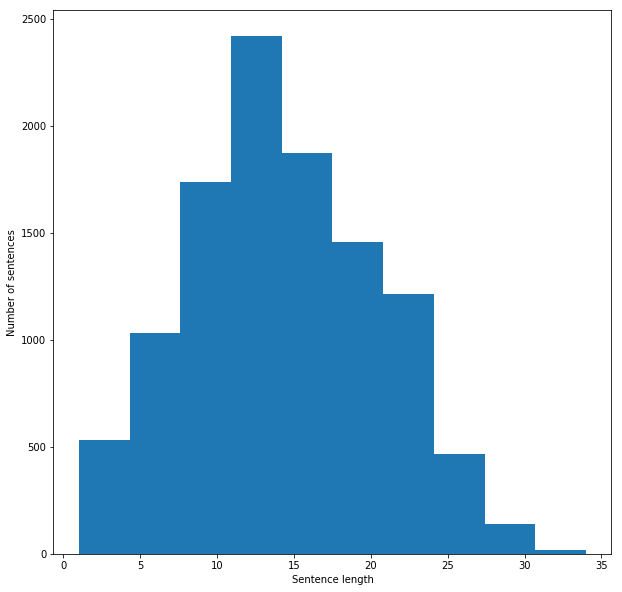

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.hist(sentence_lengths)
plt.show()

### Machine Learning

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    
    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

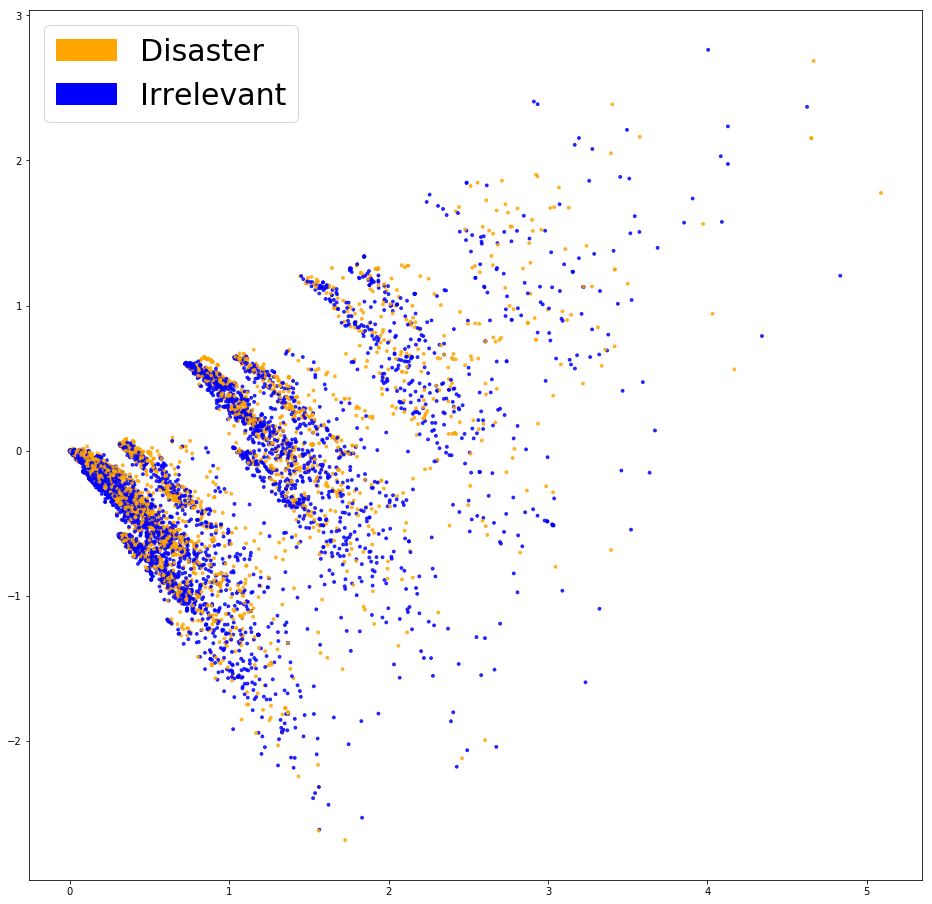

In [79]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    
    if plot:
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=0.8, c=test_labels, cmap=ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Disaster')
        green_patch = mpatches.Patch(color='blue', label='Irrelevant')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
        
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

In [80]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                        multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

In [81]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("Accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Accuracy = 0.753, precision = 0.752, recall = 0.753, f1 = 0.752


In [82]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

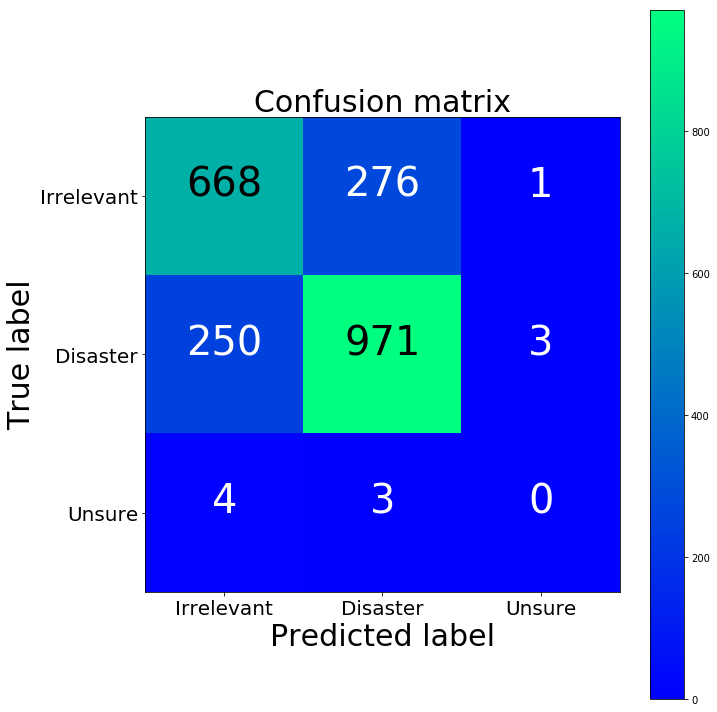

[[668 276   1]
 [250 971   3]
 [  4   3   0]]


In [84]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)